In [1]:
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam
import matplotlib.pyplot as plt
import pickle

from game import *
from agents import *
from checkers import *

In [5]:
activation_fn = lambda x: 1/(1+np.exp(-x))
# activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)

width = [128,64]
hidden_layers = len(width)
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

# n_features = 33+32
# feature_func = combined_features

n_features = 34
feature_func = checkers_features_augmented

# n_features = 12
# feature_func = checkers_features_simple

# n_features = 32
# feature_func = raw_board_features

# reward_function = checkers_reward
reward_function = raw_reward

max_moves = 500
# np.random.seed(12)
# initial_weights = np.random.normal(size=n_features)
# initial_weights = np.zeros((n_features,))
first_agent = QLearningAgent_MLP(architecture, feature_func, n_features, reward_function = reward_function, alpha=0., gamma=0.9, epsilon=0., is_learning_agent=False, weights=None)

ab1 = AlphaBetaAgent(1)
ab2 = AlphaBetaAgent(2)
ab3 = AlphaBetaAgent(3)
rand_agent = RandomAgent()

quiet = True

first_agent_turn = True
rules = ClassicGameRules(max_moves=max_moves)
game = rules.new_game(first_agent, rand_agent, first_agent_turn, quiet=quiet)
num_moves, game_state = game.run()
print('Oppn: Rand agent, RL agent play first', 'win =',game_state.is_first_agent_win(),'draw =',game_state.max_moves_done, 'moves =', num_moves)

first_agent_turn = False
rules = ClassicGameRules(max_moves=max_moves)
game = rules.new_game(first_agent, rand_agent, first_agent_turn, quiet=quiet)
num_moves, game_state = game.run()
print('Oppn: Rand agent, RL agent play second', 'win =',game_state.is_first_agent_win(),'draw =',game_state.max_moves_done, 'moves =', num_moves)


first_agent_turn = True
rules = ClassicGameRules(max_moves=max_moves)
game = rules.new_game(first_agent, ab1, first_agent_turn, quiet=quiet)
num_moves, game_state = game.run()
print('Oppn: AB1, RL agent play first', 'win =',game_state.is_first_agent_win(),'draw =',game_state.max_moves_done,'moves =', num_moves)


first_agent_turn = False
rules = ClassicGameRules(max_moves=max_moves)
game = rules.new_game(first_agent, ab1, first_agent_turn, quiet=quiet)
num_moves, game_state = game.run()
print('Oppn: AB1, RL agent play second', 'win =',game_state.is_first_agent_win(),'draw =',game_state.max_moves_done, 'moves =', num_moves)


    

Oppn: Rand agent, RL agent play first win = False draw = False moves = 42
Oppn: Rand agent, RL agent play second win = False draw = False moves = 41
Oppn: AB1, RL agent play first win = False draw = False moves = 66
Oppn: AB1, RL agent play second win = False draw = False moves = 59


In [6]:
n_train_games = 2000
n_decay = 10
n_games_test = 10
test_frequency = 10
max_random_start_depth_train = 3
max_random_start_depth_test = 3

first_agent = QLearningAgent_MLP(architecture, feature_func, n_features, reward_function = reward_function, alpha=0.001, gamma=0.9, epsilon=0.5, is_learning_agent=True, weights=None)

second_agent_list = [ab1, ab2, ab3, rand_agent]
all_results = []
all_draws = []
all_oppn_idx = []
all_weights = []
all_num = []
test_results_rand = []
test_results_1 = []
test_results_2 = []
test_results_3 = []
test_draws_rand = []
test_draws_1 = []
test_draws_2 = []
test_draws_3 = []

for n in range(n_train_games):
    
    # change alpha and epsilon after n_decay games
    if n%n_decay == n_decay-1:
        first_agent.alpha = max([0.99*first_agent.alpha, 1e-4])
        first_agent.epsilon = max([0.99*first_agent.epsilon, 0.1])
        print(n, 'Fraction of wins = ', np.mean(all_results[-n_decay:]), 'Fraction of draws = ', np.mean(all_draws[-n_decay:]))
        print(n ,'alpha = ',first_agent.alpha, 'epsilon = ',first_agent.epsilon)
    
    if n%100 == 0: print(n)
    # train against randomly selected agent
    first_agent_turn = bool(np.random.binomial(1,0.5))
    
#     second_agent_idx = np.random.choice(len(second_agent_list))  
#     all_oppn_idx.append(second_agent_idx)
#     second_agent = second_agent_list[second_agent_idx]
    second_agent = ab3
    
    rules = ClassicGameRules(max_moves=max_moves)
    game = rules.new_game(first_agent, second_agent, first_agent_turn, quiet=quiet)    
    
    # random start
    for _ in range(np.random.choice(max_random_start_depth_train)*2):
        possible_moves = game.game_state.board.get_possible_next_moves()
        next_move = possible_moves[np.random.choice(len(possible_moves),size=1)[0]]
        game.game_state.board.make_move(next_move, switch_player_turn=True)
        
    num_moves, game_state = game.run()
    
    all_num.append(num_moves)
    all_results.append(game_state.is_first_agent_win())
    all_draws.append((game_state.max_moves_done))
#     all_weights.append(first_agent.nn.weights.copy())
        
    if n%test_frequency == 0:
#         print(n)
        
        all_weights.append(first_agent.nn.weights.copy())
        
        this_test_results_rand = []
        this_test_results_1 = []
        this_test_results_2 = []
        this_test_results_3 = []
        
        this_test_draws_rand = []
        this_test_draws_1 = []
        this_test_draws_2 = []
        this_test_draws_3 = []
        
        for n in range(n_games_test):
            test_agent = QLearningAgent_MLP(architecture, feature_func, n_features, reward_function = reward_function, alpha=0.0, gamma=0.7, epsilon=0., is_learning_agent=True, weights=all_weights[-1])

            # play against ab1
            first_agent_turn = bool(np.random.binomial(1,0.5))
            rules = ClassicGameRules(max_moves=max_moves)
            game = rules.new_game(test_agent, ab1, first_agent_turn, quiet=quiet)
            
            # random start
            random_start_spots = game.game_state.board.spots
            for _ in range(np.random.choice(max_random_start_depth_test)*2):
                possible_moves = game.game_state.board.get_possible_next_moves()
                next_move = possible_moves[np.random.choice(len(possible_moves),size=1)[0]]
                game.game_state.board.make_move(next_move, switch_player_turn=True)
                random_start_spots = game.game_state.board.spots
        
            num_moves, game_state = game.run()
            this_test_results_1.append(game_state.is_first_agent_win())
            this_test_draws_1.append(game_state.max_moves_done)
            
            # play against ab2
            first_agent_turn = bool(np.random.binomial(1,0.5))
            rules = ClassicGameRules(max_moves=max_moves)
            game = rules.new_game(test_agent, ab2, first_agent_turn, quiet=quiet)
            game.game_state.board.spots = random_start_spots # set start board position to the same random start
            num_moves, game_state = game.run()
            this_test_results_2.append(game_state.is_first_agent_win())
            this_test_draws_2.append(game_state.max_moves_done)
            
            # play against ab3
            first_agent_turn = bool(np.random.binomial(1,0.5))
            rules = ClassicGameRules(max_moves=max_moves)
            game = rules.new_game(test_agent, ab3, first_agent_turn, quiet=quiet)
            game.game_state.board.spots = random_start_spots # set start board position to the same random start
            num_moves, game_state = game.run()
            this_test_results_3.append(game_state.is_first_agent_win())
            this_test_draws_3.append(game_state.max_moves_done)
            
            # play against random agent
            first_agent_turn = bool(np.random.binomial(1,0.5))
            rules = ClassicGameRules(max_moves=max_moves)
            game = rules.new_game(test_agent, rand_agent, first_agent_turn, quiet=quiet)
            game.game_state.board.spots = random_start_spots # set start board position to the same random start
            num_moves, game_state = game.run()
            this_test_results_rand.append(game_state.is_first_agent_win())
            this_test_draws_rand.append(game_state.max_moves_done)
            
        test_results_1.append(np.mean(np.array(this_test_results_1)))
        test_results_2.append(np.mean(np.array(this_test_results_2)))
        test_results_3.append(np.mean(np.array(this_test_results_3)))
        test_results_rand.append(np.mean(np.array(this_test_results_rand)))
        
        test_draws_1.append(np.mean(np.array(this_test_draws_1)))
        test_draws_2.append(np.mean(np.array(this_test_draws_2)))
        test_draws_3.append(np.mean(np.array(this_test_draws_3)))
        test_draws_rand.append(np.mean(np.array(this_test_draws_rand)))
        
        print('wins = ',test_results_1[-1],test_results_2[-1],test_results_3[-1],test_results_rand[-1])    
        print('draws = ',test_draws_1[-1],test_draws_2[-1],test_draws_3[-1],test_draws_rand[-1])    

0
wins =  0.7 0.0 0.0 1.0
draws =  0.2 0.6 0.4 0.0
9 Fraction of wins =  0.0 Fraction of draws =  0.0
9 alpha =  0.00099 epsilon =  0.495
wins =  0.5 0.0 0.1 1.0
draws =  0.4 0.7 0.1 0.0
19 Fraction of wins =  0.0 Fraction of draws =  0.0
19 alpha =  0.0009801 epsilon =  0.49005
wins =  0.6 0.0 0.1 1.0
draws =  0.3 0.3 0.5 0.0
29 Fraction of wins =  0.0 Fraction of draws =  0.0
29 alpha =  0.000970299 epsilon =  0.48514949999999996
wins =  0.1 0.0 0.0 0.9
draws =  0.7 0.2 0.1 0.0
39 Fraction of wins =  0.0 Fraction of draws =  0.0
39 alpha =  0.0009605960099999999 epsilon =  0.480298005
wins =  0.7 0.2 0.0 1.0
draws =  0.2 0.6 0.2 0.0
49 Fraction of wins =  0.0 Fraction of draws =  0.0
49 alpha =  0.0009509900498999999 epsilon =  0.47549502494999996
wins =  0.6 0.2 0.0 1.0
draws =  0.3 0.2 0.6 0.0
59 Fraction of wins =  0.0 Fraction of draws =  0.0
59 alpha =  0.0009414801494009999 epsilon =  0.47074007470049994
wins =  0.5 0.0 0.0 1.0
draws =  0.5 0.6 0.2 0.0
69 Fraction of wins =  0.

500
wins =  0.3 0.0 0.0 0.7
draws =  0.3 0.0 0.1 0.1
509 Fraction of wins =  0.0 Fraction of draws =  0.0
509 alpha =  0.0005989560064661609 epsilon =  0.29947800323308055
wins =  0.2 0.0 0.0 0.4
draws =  0.4 0.2 0.0 0.0
519 Fraction of wins =  0.0 Fraction of draws =  0.0
519 alpha =  0.0005929664464014993 epsilon =  0.2964832232007497
wins =  0.1 0.0 0.0 0.6
draws =  0.2 0.0 0.1 0.0
529 Fraction of wins =  0.0 Fraction of draws =  0.0
529 alpha =  0.0005870367819374844 epsilon =  0.2935183909687422
wins =  0.6 0.0 0.0 0.8
draws =  0.4 0.0 0.0 0.0
539 Fraction of wins =  0.0 Fraction of draws =  0.0
539 alpha =  0.0005811664141181095 epsilon =  0.29058320705905477
wins =  0.0 0.0 0.0 0.8
draws =  0.3 0.0 0.1 0.0
549 Fraction of wins =  0.0 Fraction of draws =  0.0
549 alpha =  0.0005753547499769285 epsilon =  0.28767737498846424
wins =  0.1 0.0 0.0 0.7
draws =  0.4 0.0 0.0 0.1
559 Fraction of wins =  0.0 Fraction of draws =  0.0
559 alpha =  0.0005696012024771592 epsilon =  0.28480060

wins =  0.5 0.0 0.0 1.0
draws =  0.5 0.6 0.5 0.0
999 Fraction of wins =  0.0 Fraction of draws =  0.0
999 alpha =  0.00036603234127322915 epsilon =  0.18301617063661463
1000
wins =  0.9 0.0 0.0 1.0
draws =  0.1 0.7 0.2 0.0
1009 Fraction of wins =  0.0 Fraction of draws =  0.0
1009 alpha =  0.00036237201786049685 epsilon =  0.18118600893024847
wins =  0.7 0.0 0.0 1.0
draws =  0.2 0.5 0.2 0.0
1019 Fraction of wins =  0.0 Fraction of draws =  0.0
1019 alpha =  0.0003587482976818919 epsilon =  0.179374148840946
wins =  0.7 0.0 0.0 1.0
draws =  0.1 0.7 0.5 0.0
1029 Fraction of wins =  0.0 Fraction of draws =  0.0
1029 alpha =  0.00035516081470507297 epsilon =  0.17758040735253652
wins =  0.4 0.0 0.1 1.0
draws =  0.6 0.4 0.3 0.0
1039 Fraction of wins =  0.0 Fraction of draws =  0.0
1039 alpha =  0.0003516092065580222 epsilon =  0.17580460327901115
wins =  0.7 0.2 0.0 1.0
draws =  0.2 0.4 0.3 0.0
1049 Fraction of wins =  0.0 Fraction of draws =  0.0
1049 alpha =  0.000348093114492442 epsilon 

1479 Fraction of wins =  0.0 Fraction of draws =  0.0
1479 alpha =  0.00022594815553398729 epsilon =  0.11297407776699364
wins =  0.7 0.0 0.0 1.0
draws =  0.3 0.4 0.4 0.0
1489 Fraction of wins =  0.0 Fraction of draws =  0.2
1489 alpha =  0.0002236886739786474 epsilon =  0.11184433698932371
wins =  0.4 0.0 0.0 0.9
draws =  0.5 1.0 0.1 0.0
1499 Fraction of wins =  0.0 Fraction of draws =  0.2
1499 alpha =  0.00022145178723886094 epsilon =  0.11072589361943047
1500
wins =  0.7 0.1 0.0 1.0
draws =  0.3 0.4 0.3 0.0
1509 Fraction of wins =  0.0 Fraction of draws =  0.1
1509 alpha =  0.00021923726936647233 epsilon =  0.10961863468323617
wins =  0.5 0.1 0.0 1.0
draws =  0.5 0.7 0.3 0.0
1519 Fraction of wins =  0.0 Fraction of draws =  0.0
1519 alpha =  0.0002170448966728076 epsilon =  0.1085224483364038
wins =  0.8 0.1 0.0 1.0
draws =  0.2 0.6 0.0 0.0
1529 Fraction of wins =  0.0 Fraction of draws =  0.1
1529 alpha =  0.00021487444770607953 epsilon =  0.10743722385303976
wins =  0.6 0.0 0.0 0

wins =  0.3 0.2 0.0 1.0
draws =  0.7 0.6 0.3 0.0
1999 Fraction of wins =  0.0 Fraction of draws =  0.1
1999 alpha =  0.00013397967485796178 epsilon =  0.1


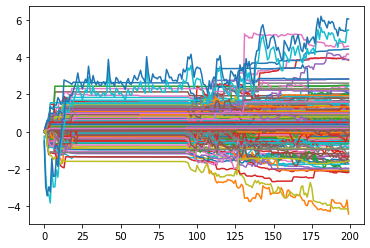

In [7]:
all_weights_array = np.stack(all_weights)
np.squeeze(all_weights_array).shape
plt.plot(np.squeeze(all_weights_array)[:,::40]);

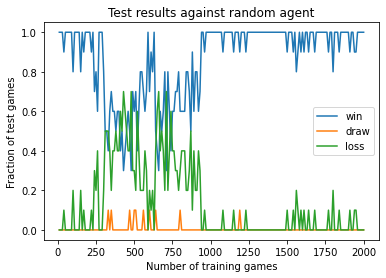

In [8]:
loss_rand = 1-np.array(test_results_rand)-np.array(test_draws_rand)
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),test_results_rand,label='win'),
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),test_draws_rand,label='draw'),
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),loss_rand,label='loss')
plt.legend()
plt.xlabel('Number of training games')
plt.ylabel('Fraction of test games')
plt.title('Test results against random agent');

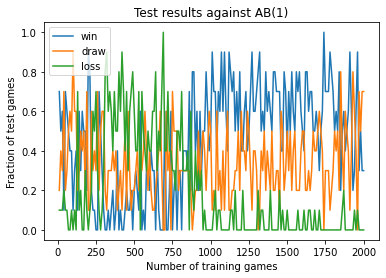

In [9]:
loss_1 = 1-np.array(test_results_1)-np.array(test_draws_1)
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),test_results_1,label='win'),
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),test_draws_1,label='draw'),
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),loss_1,label='loss')
plt.legend()
plt.xlabel('Number of training games')
plt.ylabel('Fraction of test games')
plt.title('Test results against AB(1)');

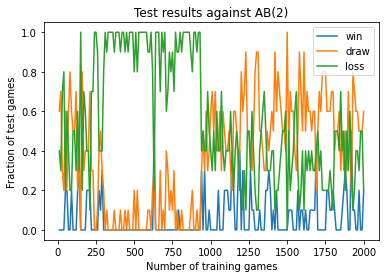

In [10]:
loss_2 = 1-np.array(test_results_2)-np.array(test_draws_2)
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),test_results_2,label='win'),
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),test_draws_2,label='draw'),
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),loss_2,label='loss')
plt.legend()
plt.xlabel('Number of training games')
plt.ylabel('Fraction of test games')
plt.title('Test results against AB(2)');

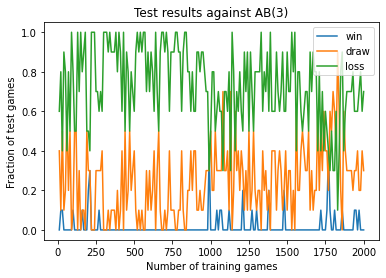

In [11]:
loss_3 = 1-np.array(test_results_3)-np.array(test_draws_3)
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),test_results_3,label='win'),
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),test_draws_3,label='draw'),
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),loss_3,label='loss')
plt.legend()
plt.xlabel('Number of training games')
plt.ylabel('Fraction of test games')
plt.title('Test results against AB(3)');

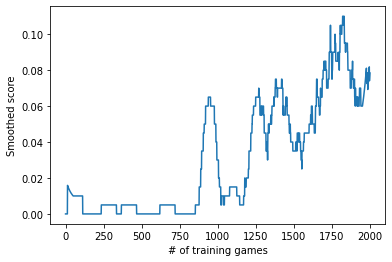

In [12]:
w = 100
calib = np.convolve(np.ones(n_train_games), np.ones(w), 'same')
all_score = 1*np.array(all_results) + 0.5*np.array(all_draws)
mean_smooth_score = np.convolve(all_score, np.ones(w), 'same') / calib
plt.plot(mean_smooth_score)
plt.xlabel('# of training games')
plt.ylabel('Smoothed score');

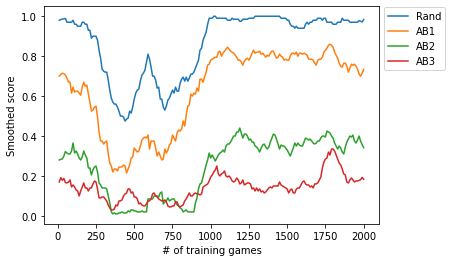

In [13]:
w = 10
calib = np.convolve(np.ones(len(test_results_rand)), np.ones(w), 'same')
all_score_rand = 1*np.array(test_results_rand) + 0.5*np.array(test_draws_rand)
all_score_1 = 1*np.array(test_results_1) + 0.5*np.array(test_draws_1)
all_score_2 = 1*np.array(test_results_2) + 0.5*np.array(test_draws_2)
all_score_3 = 1*np.array(test_results_3) + 0.5*np.array(test_draws_3)
mean_smooth_score_rand = np.convolve(all_score_rand, np.ones(w), 'same') / calib
plt.plot(np.arange(test_frequency,n_train_games+1, test_frequency),mean_smooth_score_rand, label='Rand')
mean_smooth_score_1 = np.convolve(all_score_1, np.ones(w), 'same') / calib
plt.plot(np.arange(test_frequency,n_train_games+1, test_frequency),mean_smooth_score_1, label='AB1')
mean_smooth_score_2 = np.convolve(all_score_2, np.ones(w), 'same') / calib
plt.plot(np.arange(test_frequency,n_train_games+1, test_frequency),mean_smooth_score_2,label='AB2')
mean_smooth_score_3 = np.convolve(all_score_3, np.ones(w), 'same') / calib
plt.plot(np.arange(test_frequency,n_train_games+1, test_frequency),mean_smooth_score_3,label='AB3')
plt.legend(bbox_to_anchor=(1,1.02))
plt.xlabel('# of training games')
plt.ylabel('Smoothed score');

In [14]:
data = {'all_results':all_results,
        'all_draws':all_draws,
        'all_oppn_idx':all_oppn_idx,
        'all_weights':all_weights,
        'all_num':all_num,
        'test_results_rand':test_results_rand,
        'test_results_1':test_results_1,
        'test_results_2':test_results_2,
        'test_results_3':test_results_3,
        'test_draws_rand':test_draws_rand,
        'test_draws_1':test_draws_1,
        'test_draws_2':test_draws_2,
        'test_draws_3':test_draws_3}
with open(r"Qlearning_with_MLP_33_features_raw_reward_AB3.pkl", "wb") as f:
    pickle.dump(data, f)